In [1]:
import tensorflow as tf
import pandas as pd

tf.compat.v1.disable_v2_behavior()

import codecs
import numpy as np
import math
import csv
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import recall_score, precision_score # New
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import matplotlib.pyplot as plt
import tensorflow.keras.preprocessing
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Flatten, Add, Multiply
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Activation, BatchNormalization
# regularizers
from tensorflow.keras.layers import Conv1D, Conv2D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dropout
from scipy import signal
import openpyxl
import seaborn as sns
from keijzer import *
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.layers import Dense, Input, Flatten, Add, concatenate, Dropout, Activation, Multiply
from tensorflow.keras.layers import LSTM, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D  
from tensorflow.keras.layers import Conv1D, AveragePooling1D, MaxPooling1D
from tensorflow.keras.utils import plot_model
from tensorflow.keras import activations
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
import math

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
PV = 'C:/Users/Smartgrid_ML/Documents/KMS/btm_data/korean_data/pv/seobu_pv.csv'
pv_source = pd.read_csv(PV, encoding='CP949')
pv_source = pd.DataFrame(pv_source)
pv_source = pv_source.iloc[0:1277, :]
pv_data = np.array(pv_source)

weather_17 = 'C:/Users/Smartgrid_ML/Documents/KMS/btm_data/korean_data/pv/mokpo_2017.csv'
weather_18 = 'C:/Users/Smartgrid_ML/Documents/KMS/btm_data/korean_data/pv/mokpo_2018.csv'
weather_19 = 'C:/Users/Smartgrid_ML/Documents/KMS/btm_data/korean_data/pv/mokpo_2019.csv'
weather_20 = 'C:/Users/Smartgrid_ML/Documents/KMS/btm_data/korean_data/pv/mokpo_2020.csv'

weather_17 = pd.read_csv(weather_17, encoding='CP949')
weather_18 = pd.read_csv(weather_18, encoding='CP949')
weather_19 = pd.read_csv(weather_19, encoding='CP949')
weather_20 = pd.read_csv(weather_20, encoding='CP949')
weather = pd.concat([weather_17,weather_18,weather_19,weather_20])
weather_data = np.array(weather)

pv_data = np.nan_to_num(pv_data)
weather_data = np.nan_to_num(weather_data)
pv_dat = pv_data[:, 2:]
weather_dat = weather_data[:, 3:]
pv_dat = pv_dat.reshape(-1,1)

dataset = np.hstack([pv_dat, weather_dat])
index = ['Measured PV', 'Temperature C', 'Rainfall', 'Wind speed', 'Wind direction', 'Humidity', 'Air pressure', 'Dew point C', 'Sunshine', 'Solar radiation', 'Snowfall', 'Cloud cover', 'Surface temp C']

df = pd.DataFrame(dataset, columns=index)
df.head()
df = df.fillna(0)
min_max_scaler = preprocessing.MinMaxScaler()
norm_df = pd.DataFrame(min_max_scaler.fit_transform(df), 
                             columns=df.columns, 
                             index=df.index)
norm_df.head()

,Measured PV,Temperature C,Rainfall,Wind speed,Wind direction,Humidity,Air pressure,Dew point C,Sunshine,Solar radiation,Snowfall,Cloud cover,Surface temp C
0,0.0,0.354298,0.0,0.023256,0.000000,0.89,0.189696,0.444681,0.0,0.0,0.0,0.6,0.141834
1,0.0,0.339623,0.0,0.104651,0.444444,0.93,0.189696,0.442553,0.0,0.0,0.0,0.0,0.117479
2,0.0,0.320755,0.0,0.046512,0.388889,0.93,0.177986,0.423404,0.0,0.0,0.0,0.0,0.103152
3,0.0,0.303983,0.0,0.087209,0.444444,0.94,0.170960,0.410638,0.0,0.0,0.0,0.0,0.095989
4,0.0,0.287212,0.0,0.104651,0.444444,0.95,0.161593,0.395745,0.0,0.0,0.0,0.0,0.088825


C:\Users\Smartgrid_ML\Documents\KMS\btm_data\Korean_Solar\Final\02_Feature Selection\keijzer.py:70: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Saving heatmap


<Figure size 432x288 with 0 Axes>

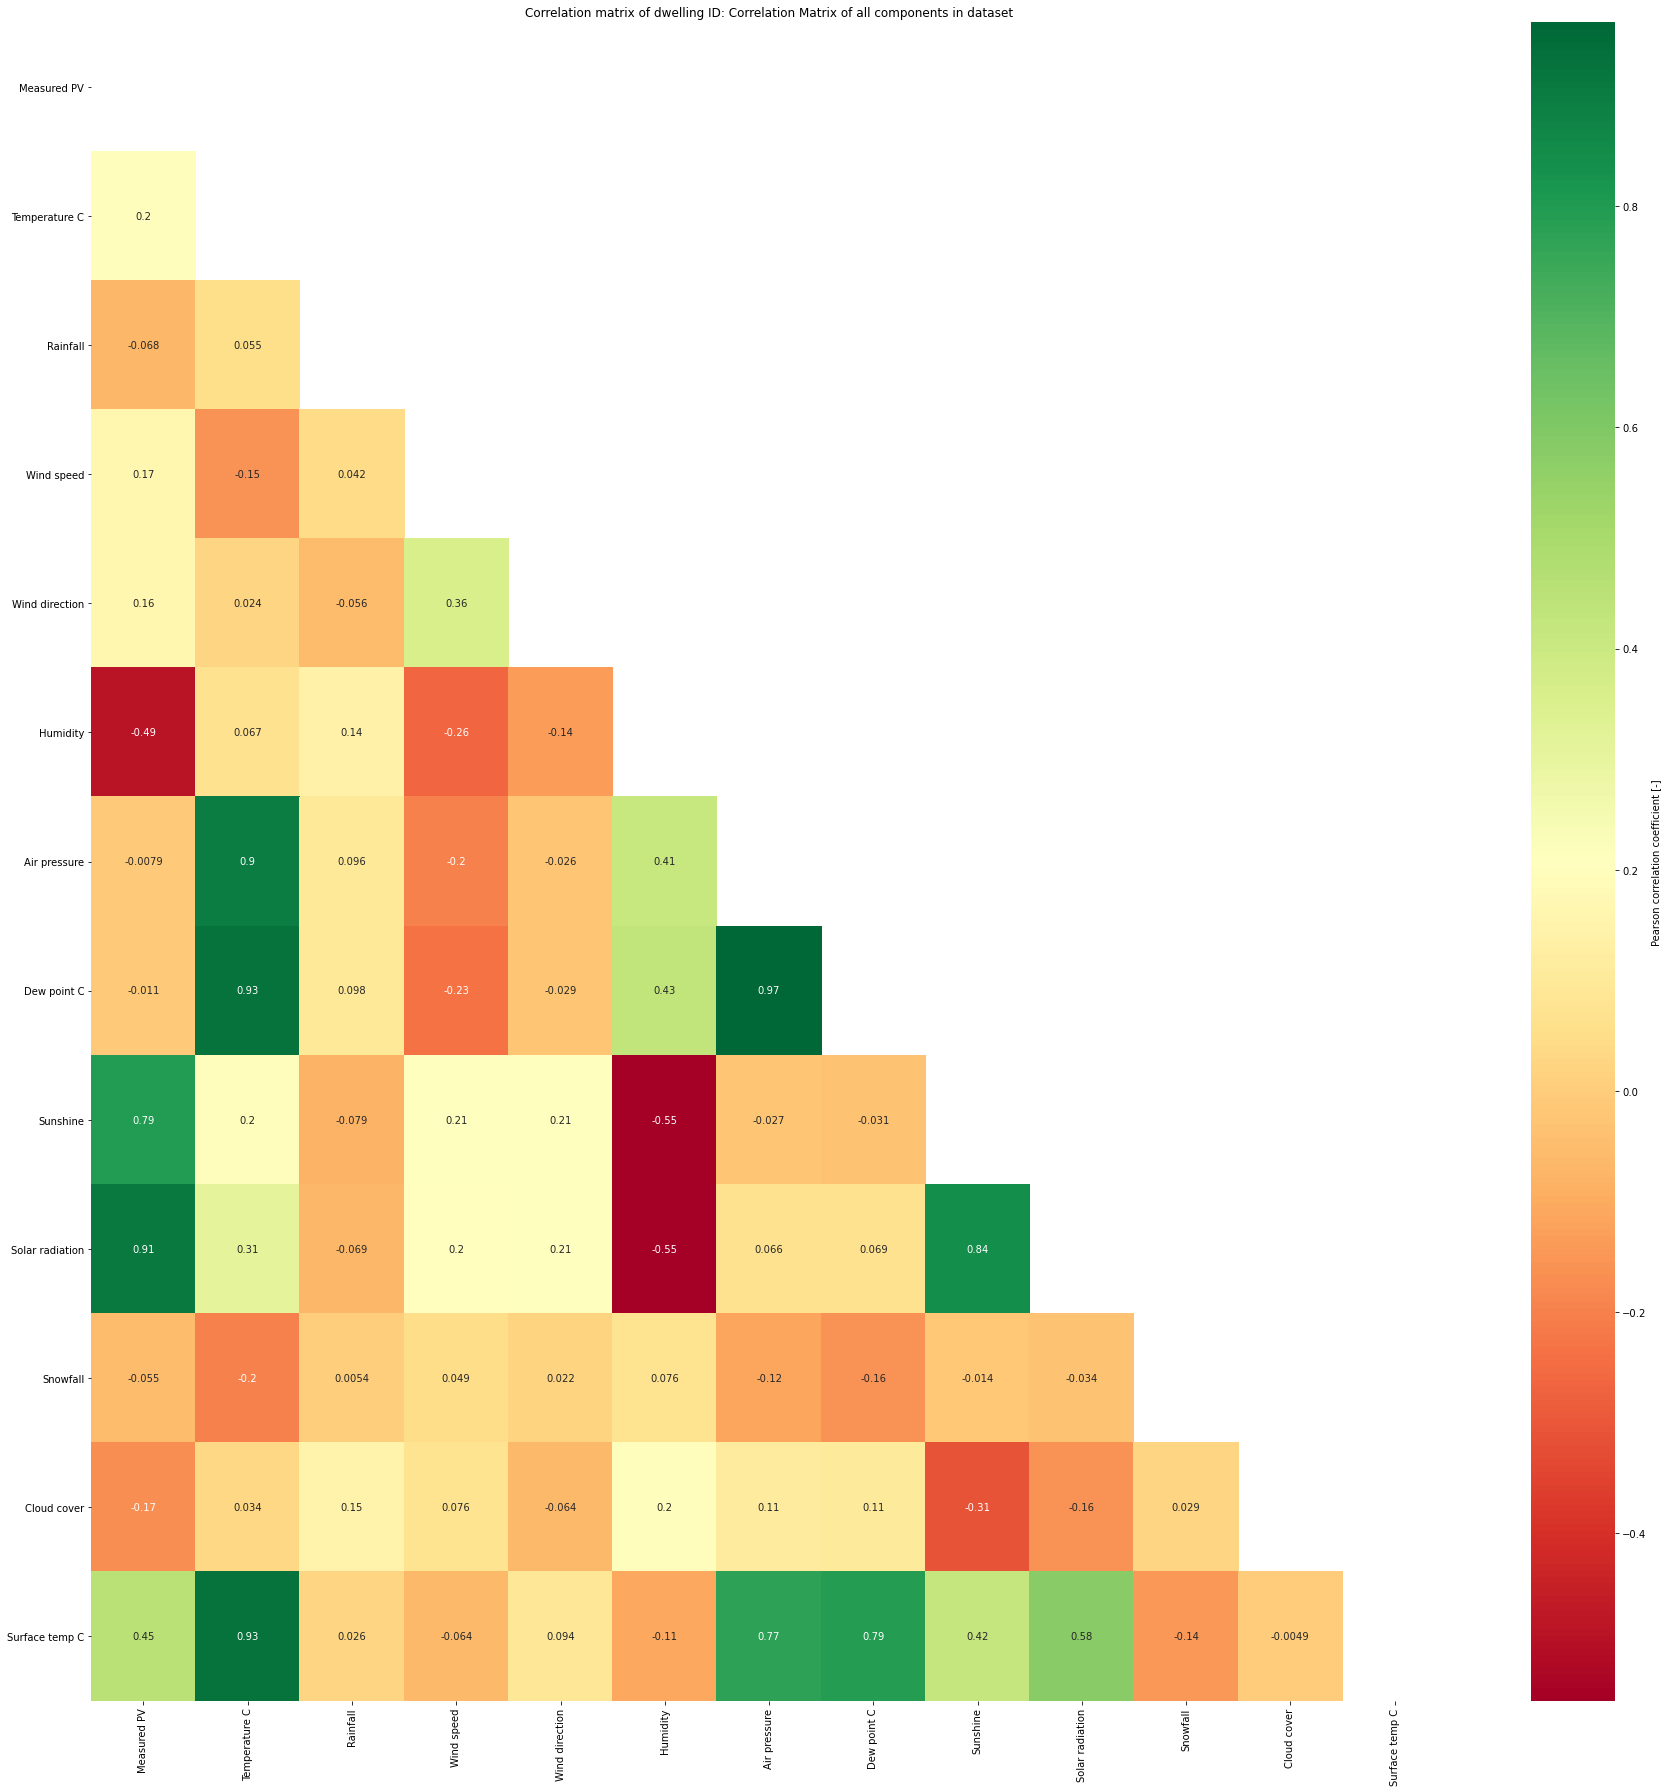

In [3]:
import seaborn as sns
from keijzer import *

fig = create_corr_matrix(norm_df, 'Correlation Matrix of all components in dataset', True, size=(25,25))
fig.savefig('correlation_matrix.png')

In [4]:
norm_df = np.array(norm_df)
norm_df2 = norm_df[:,(0, 1, 4, 5, 6, 8, 9, 11, 12)]

In [5]:
def get_flops(model):
    run_meta = tf.RunMetadata()
    opts = tf.profiler.ProfileOptionBuilder.float_operation()

    # We use the Keras session graph in the call to the profiler.
    flops = tf.profiler.profile(graph=K.get_session().graph,
                                run_meta=run_meta, cmd='op', options=opts)

    return flops.total_float_ops  # Prints the "flops" of the model.

def create_dataset(dataset, timesteps, output_timesteps):
    dataX, dataY = [], []
    for i in range(len(dataset) - timesteps -output_timesteps - 1):
        a = dataset[i:(i + timesteps), :]
        dataX.append(a)
        dataY.append(dataset[(i + timesteps):(i+timesteps+output_timesteps), :])
    return np.array(dataX), np.array(dataY)

class LossHistory(tensorflow.keras.callbacks.Callback):  # history = LossHistory()
    def init(self):  # history.init()
        self.losses = []
        # self.accs = []
        self.val_losses = []
        # self.val_accs = []
        self.rmses = []
        self.mses = []
        self.maes = []
        self.mapes = []
        self.val_rmses = []
        self.val_mses = []
        self.val_maes = []
        self.val_mapes = []

    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        # self.accs.append(logs.get('acc'))
        self.val_losses.append(logs.get('val_loss'))
        # self.val_accs.append(logs.get('val_accuracy
        self.rmses.append(logs.get('root_mean_squared_error'))
        self.mses.append(logs.get('mean_squared_error'))
        self.maes.append(logs.get('mean_absolute_error'))
        self.mapes.append(logs.get('mean_absolute_percentage_error'))
        self.val_rmses.append(logs.get('val_root_mean_squared_error'))
        self.val_mses.append(logs.get('val_mean_squared_error'))
        self.val_maes.append(logs.get('val_mean_absolute_error'))
        self.val_mapes.append(logs.get('val_mean_absolute_percentage_error'))

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [6]:
timesteps = 30
output_timesteps = 12

X, Y = create_dataset(norm_df2, timesteps, output_timesteps)

trX = X[:18389, :, :]
vaX = X[18389:21447, :, :]
teX = X[21447:, :, :]
trY = Y[:18389, :, 0]
vaY = Y[18389:21447, :, 0]
teY = Y[21447:, :, 0]

print(trX.shape)
print(trY.shape)
print(teX.shape)

(18389, 30, 9)
(18389, 12)
(9158, 30, 9)


In [8]:
with tf.device('/gpu:0'):
    def make_model(alpha):
        beta = math.sqrt(2/alpha/1.44)
        num_features = 9
        hfilters = 256
        hkernel_size1 = 2
        hkernel_size2 = 4
        visible1 = Input(shape=(timesteps, num_features))
        per1 = Permute((2,1))(visible1)
        den1a = Dense(timesteps, activation='tanh')(per1)
        den1b = Dense(timesteps, activation='sigmoid')(per1)
        den1 = Multiply()([den1a, den1b])
        per2 = Permute((2,1), name='attention_vec')(den1)
        mul1 = Multiply()([visible1, per2])
        d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=1)(mul1)
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=2)(d1)
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        res01 = Add()([d1, visible1])   # (100, 25) (100, 25)
        d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=2)(res01)
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=4)(d1)    
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        res02 = Add()([d1, res01])   # (100, 25) (100, 25)
        d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=4)(res02) 
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=8)(d1) 
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        res03 = Add()([d1, res02])   # (100, 25) (100, 25)
        d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=8)(res03)
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=16)(d1)  
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        res04 =Add()([d1, res03])   # (100, 25) (100, 25)
        d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=16)(res04)
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=32)(d1)
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        res05 = Add()([d1, res04])   # (100, 25) (100, 25)
        d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=32)(res05) 
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=16)(d1)   
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        res06 = Add()([d1, res05])   # (100, 25) (100, 25)
        d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=16)(res06) 
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=8)(d1)
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        res07 = Add()([d1, res06])   # (100, 25) (100, 25)
        d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=8)(res07)  
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=4)(d1) 
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        res08 = Add()([d1, res07])   # (100, 25) (100, 25)
        d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=4)(res08)   
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=2)(d1)  
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        res09 = Add()([d1, res08])   # (100, 25) (100, 25)
        d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=2)(res09) 
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=1)(d1)    
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])

        res10 = Add()([d1, res09])

        print('res10 :', res10.shape)  # (None, 24, 11) 

        out = Conv1D(512, 1, padding='same', activation='relu')(res10)   # 256, 11X10=110  
        out = Dropout(0.2)(out)   

        out = Conv1D(256, 1, padding='same', activation='relu')(out) # 512,  110X5=550
        out = Dropout(0.2)(out)  

        out = GlobalAveragePooling1D()(out) # pool_size=2, strides=1

        out = Dense(output_timesteps)(out) 
        model10 = Model(inputs=[visible1], outputs=[out])
        model10.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae', 'mape', 'accuracy'])
        return model10
    
    alpha_cand = [1.0, 1.05, 1.1, 1.15]
    
    my_classifier = KerasClassifier(make_model, batch_size = 100)
    validator = GridSearchCV(my_classifier, param_grid = {'alpha': alpha_cand, 'epochs' : [200]})
    
    validator.fit(trX, trY, verbose=2)
    
    print('The parameters of the best model are: ')
    print(validator.best_params_)

res10 : (?, 30, 9)
Train on 14711 samples
Epoch 1/200
14711/14711 - 7s - loss: 0.0267 - mean_squared_error: 0.0267 - mean_absolute_error: 0.1138 - mean_absolute_percentage_error: 31391168.0000 - acc: 0.4833
Epoch 2/200
14711/14711 - 5s - loss: 0.0135 - mean_squared_error: 0.0135 - mean_absolute_error: 0.0728 - mean_absolute_percentage_error: 11359801.0000 - acc: 0.6111
Epoch 3/200
14711/14711 - 4s - loss: 0.0129 - mean_squared_error: 0.0129 - mean_absolute_error: 0.0696 - mean_absolute_percentage_error: 9802861.0000 - acc: 0.6138
Epoch 4/200
14711/14711 - 5s - loss: 0.0120 - mean_squared_error: 0.0120 - mean_absolute_error: 0.0657 - mean_absolute_percentage_error: 8375633.0000 - acc: 0.6227
Epoch 5/200
14711/14711 - 4s - loss: 0.0116 - mean_squared_error: 0.0116 - mean_absolute_error: 0.0639 - mean_absolute_percentage_error: 7494390.5000 - acc: 0.6242
Epoch 6/200
14711/14711 - 5s - loss: 0.0112 - mean_squared_error: 0.0112 - mean_absolute_error: 0.0623 - mean_absolute_percentage_error:

C:\Users\Smartgrid_ML\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


res10 : (?, 30, 9)
Train on 14711 samples
Epoch 1/200
14711/14711 - 5s - loss: 0.0277 - mean_squared_error: 0.0277 - mean_absolute_error: 0.1149 - mean_absolute_percentage_error: 32013708.0000 - acc: 0.4879
Epoch 2/200
14711/14711 - 5s - loss: 0.0144 - mean_squared_error: 0.0144 - mean_absolute_error: 0.0741 - mean_absolute_percentage_error: 11622605.0000 - acc: 0.6163
Epoch 3/200
14711/14711 - 5s - loss: 0.0130 - mean_squared_error: 0.0130 - mean_absolute_error: 0.0685 - mean_absolute_percentage_error: 9370329.0000 - acc: 0.6253
Epoch 4/200
14711/14711 - 5s - loss: 0.0123 - mean_squared_error: 0.0123 - mean_absolute_error: 0.0658 - mean_absolute_percentage_error: 8215860.5000 - acc: 0.6288
Epoch 5/200
14711/14711 - 5s - loss: 0.0118 - mean_squared_error: 0.0118 - mean_absolute_error: 0.0632 - mean_absolute_percentage_error: 7255570.5000 - acc: 0.6316
Epoch 6/200
14711/14711 - 5s - loss: 0.0113 - mean_squared_error: 0.0113 - mean_absolute_error: 0.0610 - mean_absolute_percentage_error: